In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

In [2]:
def build_conv_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Кодировщик
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Декодировщик
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [3]:
def build_dense_autoencoder():
    input_img = layers.Input(shape=(784,))

    # Кодировщик
    encoded = layers.Dense(64, activation='relu')(input_img)

    # Декодировщик
    decoded = layers.Dense(784, activation='sigmoid')(encoded)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [4]:
# Загрузка и подготовка данных MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
# Обучение сверточного автоэнкодера
conv_autoencoder = build_conv_autoencoder()
conv_autoencoder.fit(x_train, x_train,
                     epochs=50,
                     batch_size=256,
                     shuffle=True,
                     validation_data=(x_test, x_test))

# Обучение полносвязного автоэнкодера
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

dense_autoencoder = build_dense_autoencoder()
dense_autoencoder.fit(x_train_flat, x_train_flat,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(x_test_flat, x_test_flat))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 120s 497ms/step - loss: 0.2859 - val_loss: 0.0869
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 136s 471ms/step - loss: 0.0855 - val_loss: 0.0797
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 110s 467ms/step - loss: 0.0798 - val_loss: 0.0767
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 141s 464ms/step - loss: 0.0772 - val_loss: 0.0749
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 143s 470ms/step - loss: 0.0754 - val_loss: 0.0735
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 108s 461ms/step - loss: 0.0741 - val_loss: 0.0726
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 111s 472ms/step - loss: 0.0731 - val_loss: 0.0720
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 110s 470ms/step - loss: 0.0725 - val_loss: 0.0714
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 141s 465ms/step - loss: 0.0719 - val_loss: 0.0710
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 111s 471ms/step - loss: 0.0715 - val_loss: 0.0712
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 142s 469ms/step - loss: 0.0711 - val_loss: 0.0702
Epoch 12

In [9]:
def interpolate_images(img1, img2, num_steps=10):
    alpha_values = np.linspace(0, 1, num_steps)
    interpolated_images = []

    for alpha in alpha_values:
        interpolated_image = (1 - alpha) * img1 + alpha * img2
        interpolated_images.append(interpolated_image)

    return np.array(interpolated_images)


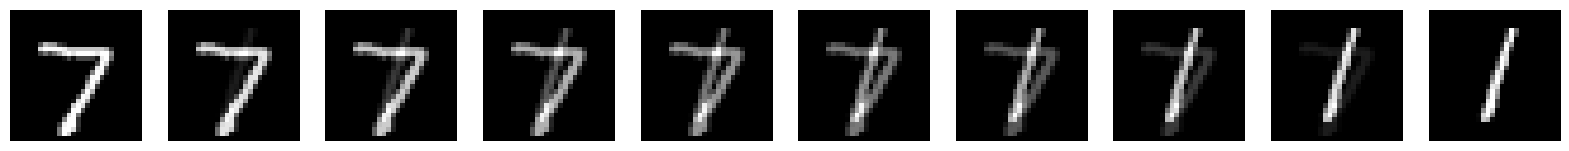

In [15]:
# Пример интерполяции между двумя изображениями
img1 = x_test[0].reshape(28, 28)
img2 = x_test[2].reshape(28, 28)

interpolated_images = interpolate_images(img1, img2)

# Визуализация интерполированных изображений
plt.figure(figsize=(20, 4))
for i in range(interpolated_images.shape[0]):
    plt.subplot(1, interpolated_images.shape[0], i + 1)
    plt.imshow(interpolated_images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [12]:
def add_noise(images):
    noise_factor = 0.5
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noisy_x_test = add_noise(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


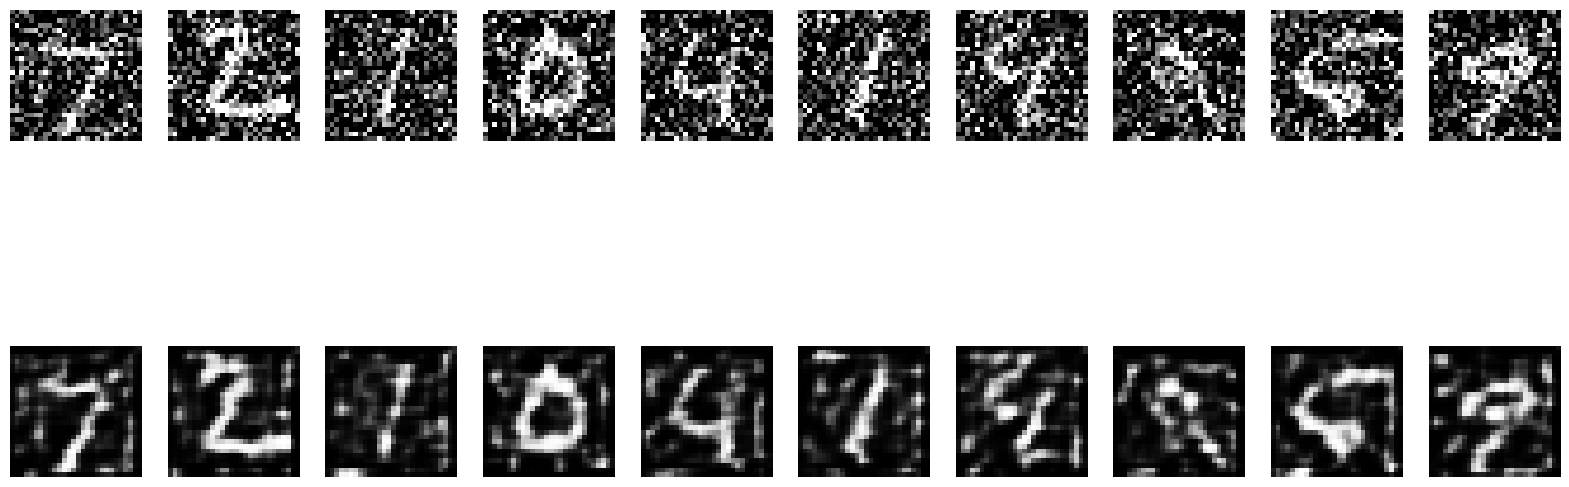

In [16]:
# Визуализация шумных изображений и их реконструкции
decoded_noisy_images = conv_autoencoder.predict(noisy_x_test)

plt.figure(figsize=(20, 8))
for i in range(10):
    # Шумное изображение
    plt.subplot(2, 10, i + 1)
    plt.imshow(noisy_x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Реконструированное изображение
    plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_noisy_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()